In [5]:
# imports
import librosa, os
from scipy.linalg import svd, toeplitz
from scipy.stats import zscore
import numpy as np
from scipy.stats import entropy
from statsmodels.tsa.stattools import acf

from tqdm.notebook import tqdm
from random import sample
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sklearn import svm, neighbors, model_selection
from statistics import mean
from sklearn.metrics import classification_report

from pyha_analyzer import PyhaTrainer, PyhaTrainingArguments, extractors
import torch
import lap

from utils import extract_coral, get_egci


In [6]:
# getting all the wavs

audio_path = "/home/a.jajodia.229/acoustic/local_data/coral"

train, test, split = extract_coral(audio_path, 5, False)

min size is 15538 from dataset Paola
sampling 15538 from (Paola, 0)
sampling 15538 from (Paola, 1)
sampling 1294 from (Williams_et_al_2024, 0)
sampling 1294 from (Williams_et_al_2024, 1)
Loaded: 33664 samples


Casting the dataset:   0%|          | 0/23564 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3030 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7070 [00:00<?, ? examples/s]

In [ ]:
df = pd.DataFrame(train[0:100])

In [ ]:

processed_data = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    if row['dataset'] == "Williams_et_al_2024":
        
        egci = get_egci(row, split=True)
    else:
        egci = get_egci(row, split=False)
    if egci is not None:
        processed_data += egci

processed_data = pd.DataFrame.from_records(processed_data)


  0%|          | 0/100 [00:00<?, ?it/s]

no audio here :(
no audio here :(
no audio here :(


In [ ]:


cotas = pd.read_csv("Cotas_HxC_bins_512.csv")
noise = pd.read_csv("coloredNoises_512.csv")

fig = plt.figure(figsize=(7,5))

sns.scatterplot(processed_data, x='entropy', y='complexity', hue='gt', style='site', alpha=0.2)

plt.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
plt.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')


plt.xlim([0, 1])
plt.ylim([0, np.max(cotas['Complexity'])+0.01])
plt.ylabel('Complexity [Cf]')
plt.xlabel('Entropy [Hf]')
lgnd = plt.legend(loc = 'best')
# set sizes of points in legend to be the same
for handle in lgnd.legend_handles:
    try:
        handle.set_sizes([200.0])
    except:
        continue
fig.axes[0].set_title(f"Reef Degradation By EGCI")

NameError: name 'pd' is not defined

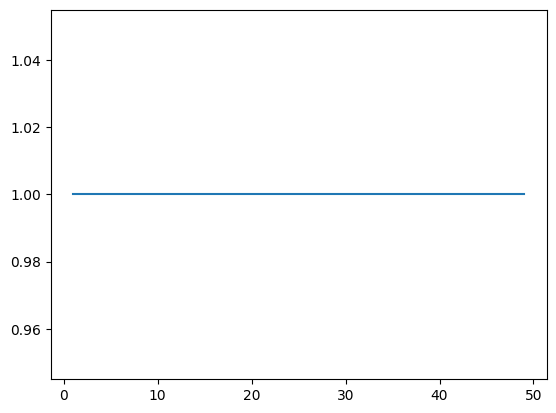

In [ ]:
accs = []
params = [i for i in range(1,50, 1)]


for i in range(1, 50, 1):
    clf = neighbors.KNeighborsClassifier(n_neighbors = i)


    X = processed_data[['entropy', 'complexity']]
    y = (processed_data['gt'] == "Degraded reef")

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.33, random_state=42)
    clf.fit(X_train, y_train)

    actual = mean(clf.predict(X_test) == y_test)
    
    accs.append(actual)

plt.plot(params, accs)

In [ ]:
actual = sum(clf.predict(X_test) == y_test)/len(y_test)

actual

1.0

In [ ]:
permutations = []
# permutation testing
for i in range(10**4):
    permutations.append(mean(np.random.choice(y_test, len(y_test)) == y_test))

num_sig = 0
for perm in permutations:
    if perm > actual:
        num_sig += 1

p = num_sig / 10**4

In [ ]:
report = classification_report(y_test, clf.predict(X_test)) 

In [ ]:
print(report)

              precision    recall  f1-score   support

       False       0.93      0.85      0.89      5012
        True       0.81      0.91      0.86      3566

    accuracy                           0.88      8578
   macro avg       0.87      0.88      0.87      8578
weighted avg       0.88      0.88      0.88      8578

